<a href="https://colab.research.google.com/github/hrssilva/INF01017-ML_comparison/blob/master/T2_2023_02_An%C3%A1lise_de_agrupamentos_com_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Instituto de Informática - UFRGS**
## Disciplina INF01017 - Aprendizado de Máquina
#### *Profa. Mariana Recamonde-Mendoza (mrmendoza@inf.ufrgs.br)*
### **Trabalho 2 - Análise de agrupamentos com K-means**
<br>

**Grupo**:
*   Haroldo Rojas de Souza Silva - 315933
*   Rafael Trevisan - 301922


---
***Observação:*** Este notebook é disponibilizado aos alunos como ponto de partida para o desenvolvimento do trabalho prático 2 (T2) da disciplina INF01017.


---

***ENTREGA:*** A entrega deste trabalho deve ser feita enviando o **link do Google Colab** com a solução do grupo, com a opção de deixar **as saídas do notebook salvas**, e o PDF exportado do Google Colab.



# Segmentação de Clientes com Algoritmo K-Means

O conjunto de dados a ser utilizado nesse trabalho foi adaptado de um problema de classificação de risco de crédito para clientes bancários. Os dados a serem analisados não possuem rótulos (classes) e possuem apenas um subconjunto previamente selecionado dos atributos utilizados para descrever as instâncias analisadas. O objetivo é realizar o processo de segmentação de clientes que solicitaram crédito bancário, que consiste em separar os clientes em grupos menores com base em características comuns entre eles. A partir destes grupos gerados (aqui denominados clusters), a empresa pode oferecer uma comunicação mais assertiva e personalizada aos seus clientes, e melhor compreender sobre os interesses e necessidades dos seus clientes ao traçar perfis de clientes (também denominados *personas*).


Os atributos disponíveis estão descritos abaixo:

*   **Age.** Idade (numérico)
*   **Credit amount.** Valor do crédito (numérico, em DM - Deutsch Mark)
*   **Duration.** Duração (numérico, em mês)
*   **Sex.** Sexo (categórico: masculino, feminino)
*   **Job.** Emprego (categórico: 0 - não qualificado e não residente, 1 - não qualificado e residente, 2 - qualificado, 3 - altamente qualificado)
*   **Housing.** Imóvel (categórico: próprio, alugado ou gratuito)
*   **Saving Account.** Poupança (categórico: pequena, moderada, bastante rico, rico)
*   **Checking Account.** Conta corrente (categórico: pequena, moderada, bastante rico, rico)
*   **Purpose.** Finalidade (categórico: carro, móveis/equipamentos, rádio/TV, eletrodomésticos, reparos, educação, negócios, férias/outros)





In [62]:
##importando bilbiotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

Lendo os dados e visualizando a estrutura para as primeiras instâncias

In [63]:
data = pd.read_csv("https://drive.google.com/uc?export=view&id=1Jp-y1djRI3sCT6_JTBkfLn1FOL4qMHsv",  )

In [64]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


A primeira coluna pode ser removida, pois é apenas um identificador (da instância ou da linha).

In [65]:
data.drop(data.columns[0], inplace=True, axis=1)

Inspecionando o tamanho do base de dados, os tipos dos atributos e a ocorrência de valores faltantes.

In [66]:
print("O conjunto de dados possui {} instâncias (clientes) e {} colunas (atributos).".format(data.shape[0],data.shape[1]))

O conjunto de dados possui 1000 instâncias (clientes) e 9 colunas (atributos).


In [67]:
print("Valores faltantes (%) por atributo:\n{}".format((data.isnull().sum()/data.shape[0])*100))

Valores faltantes (%) por atributo:
Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
dtype: float64


Os valores faltantes ocorrem nos atributos Saving accounts e Checking account. Provavelmente são clientes que não possuem algum destes tipos de conta. Neste caso, optamos por não imputar os valores faltantes.

In [68]:
print("Tipo de dado por atributo:\n{}".format(data.dtypes))

Tipo de dado por atributo:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Embora o atributo Job esteja codificado como inteiro, ele possui uma interpretação **categórica**. Vamos fazer a conversão de tipo e separar os atributos em vetores de categóricos e numéricos para facilitar a análise exploratória dos dados.

In [69]:
## Converte o atributo job para object.
data_types_dict = {'Job': object}

data = data.astype(data_types_dict)

## Separa os atributos em vetores, de acordo com o tipo de dado (categórico ou numérico)
cat_columns=list(data.select_dtypes(include=["object"]).columns)
print(cat_columns)

num_columns=list(data.select_dtypes(include=["int64", "float64"]).columns)
print(num_columns)

## Separa os dados em dois dataframes, de atributos numéricos e categóricos
data_num = data[num_columns]
data_cat = data[cat_columns]

['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
['Age', 'Credit amount', 'Duration']


In [70]:
data_num.describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


A análise de agrupamento para identificar perfis de clientes será feita a partir dos dados numéricos: **Age, Credit Amount, Duration**.


Uma vez definidos os clusters, os demais atributos serão empregados para uma interpretação mais aprofundada destes clusters e dos respectivos perfis de clientes que representam.




### **Análise Exploratória dos Dados**

Nas células abaixo, vamos realizar uma análise exploratória dos dados.

Primeiramente, vamos observar a relação entre os três atributos numéricos através de um gráfico 3D e de gráficos que traçam a relação par a par entre eles.

Text(0.5, 0, 'Age')

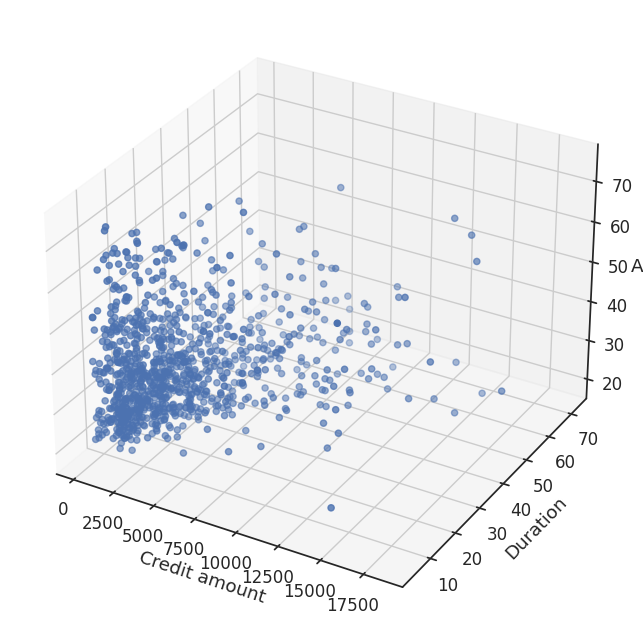

In [71]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

In [72]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

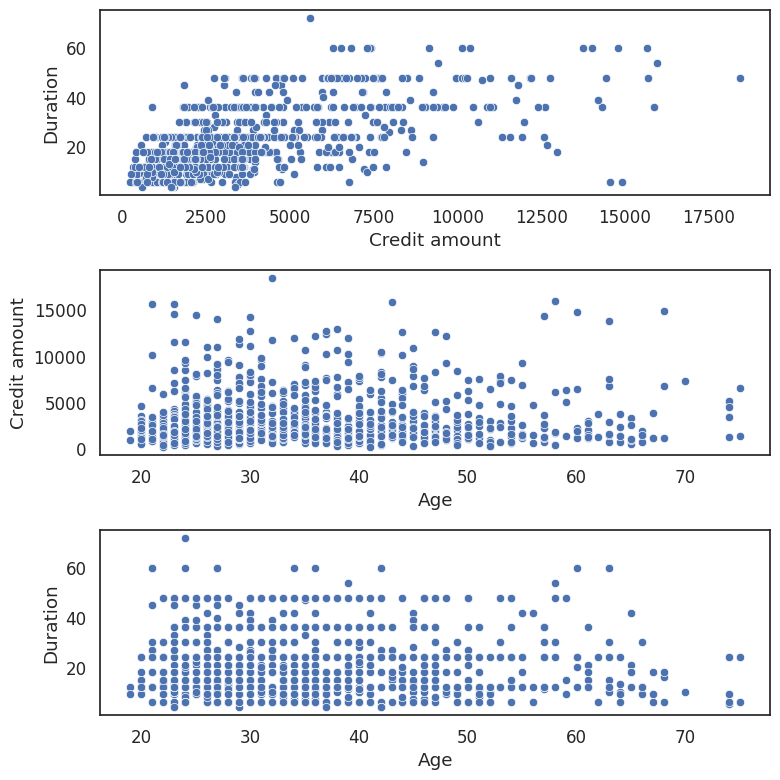

In [73]:
scatters(data)

Estas análises sugerem a existência de uma correlação positiva entre Credit amount e Duration. Esta correlação é pertinente, visto que valores maiores de créditos tendem a ser pagos em um prazo maior.

Podemos observar, também, a distribuição de cada atributo numérico.

In [74]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

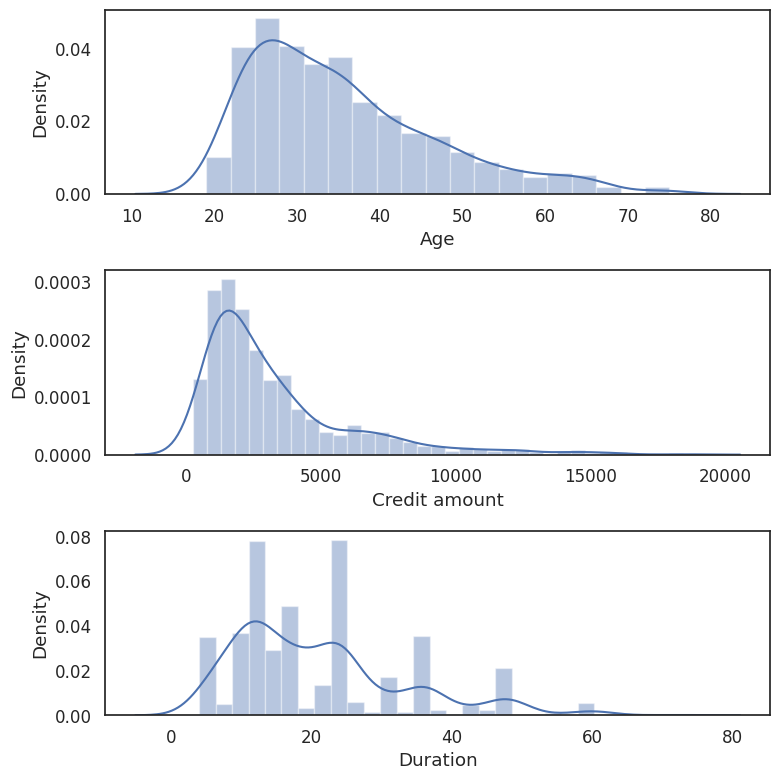

In [75]:
distributions(data_num)

Com a análise das distribuições, percebemos de forma ainda mais clara que os atributos variam em escalas diferentes. Em algoritmos que lidam com medidas de proximidade, como é o caso do k-means, é importante normalizar os dados para que os valores dos diferentes atributos estejam em ordens de grandeza similares, e assim exerçam o mesmo impacto no aprendizado. Iremos utilizar o método StandardScaler (também chamado por padronização).

In [76]:
scaler = StandardScaler()
data_num_std = scaler.fit_transform(data_num)
data_num_std = pd.DataFrame(data_num_std, columns=num_columns)

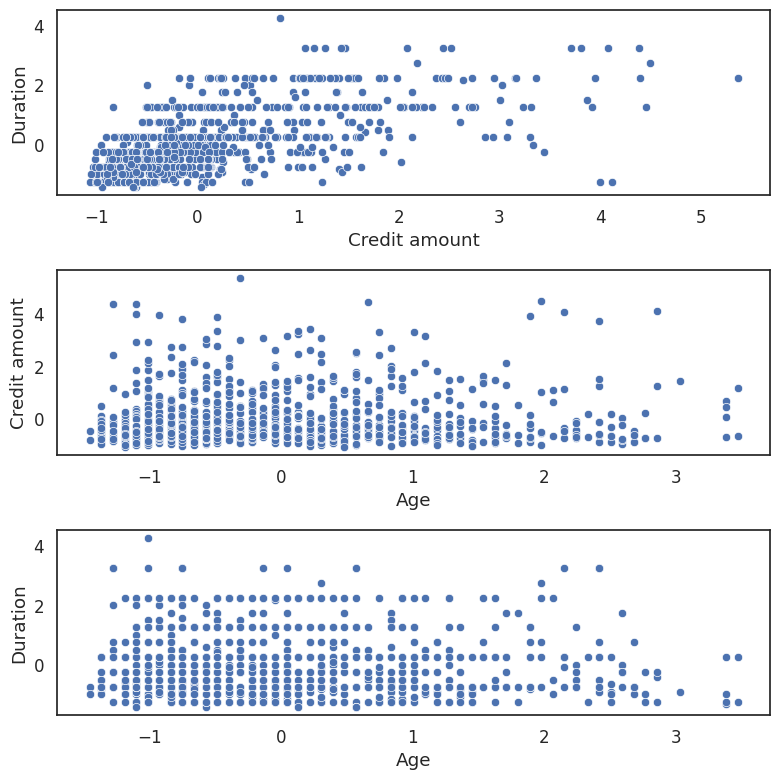

In [77]:
## Visualizando novamente os dados, após padronização
## (Apenas para entender, visualmente, que o padrão na relação dos dados não muda)
scatters(data_num_std)

Text(0.5, 0, 'Age')

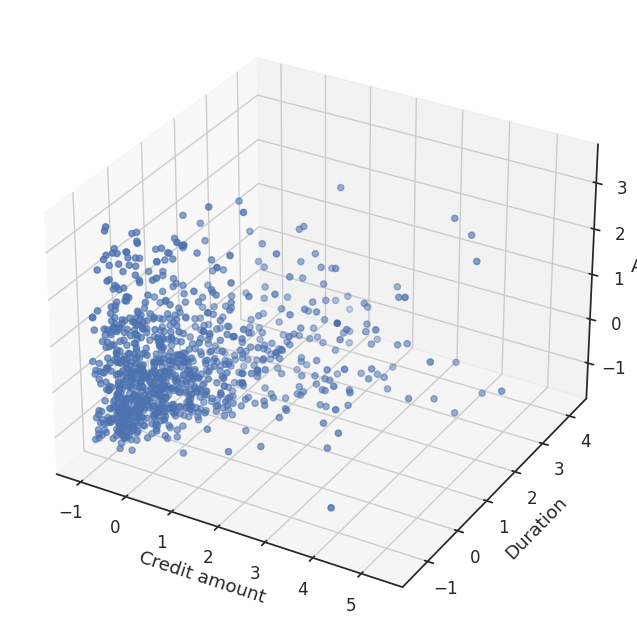

In [78]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_num_std["Credit amount"], data_num_std["Duration"], data_num_std["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

### **Aplicação do K-means**

Nesta seção, o grupo deve realizar a aplicação do algoritmo [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) no dataframe `data_num_std`, seguindo os passos listados abaixo:


1.   Faça a análise do k-means para diferentes números de clusters. Sugere-se testar de 1 a 20. Crie um vetor para armazenar a soma do quadrado das distâncias das instâncias até o centróide mais próximo durante o loop (também chamado de inércia, e disponível no campo *inertia_* do objeto retornado pelo método KMeans, por exemplo, kmeans.inertia_)  
2.   Faça um gráfico da inércia (eixo y) para os diferentes valores de k (eixo x), a fim de determinar o melhor valor de k pelo método do cotovelo (Elbow method).
3.   Escolha o melhor valor de k para os dados, repetindo a execução do k-means com o k escolhido e gerando a configuração final de clusters.



In [79]:
max_clusters = 10 #@param {type:"integer"}
inertias=[]
for ii in range(1,max_clusters):
   ## executar o k-means com ii clusters
   km = KMeans(ii)
   km.fit(data_num_std)
   ## armazenar o respectivo valor de .inertia_ no vetor inertia
   inertias.append(km.inertia_)

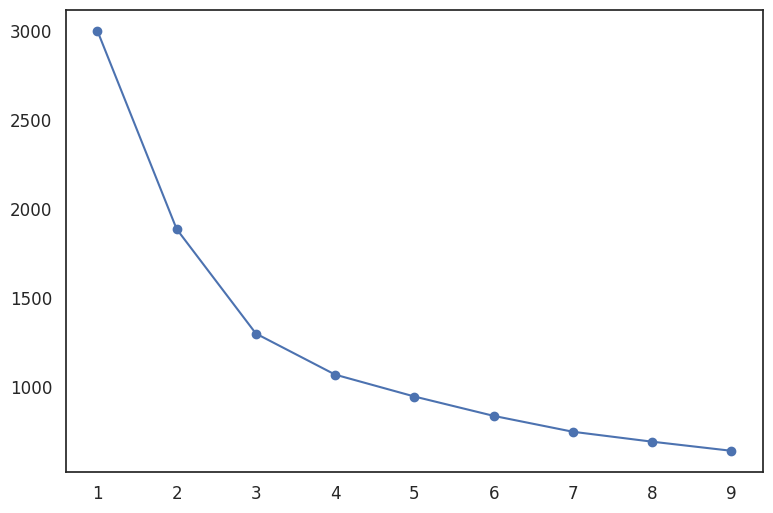

In [80]:
plt.figure()
plt.plot(range(1,max_clusters),inertias, marker='o')

In [81]:
num_clusters = 4 #@param {type:"integer"}

kmeans_final = KMeans(num_clusters)
kmeans_final.fit(data_num_std)
labels=kmeans_final.labels_

A célula abaixo gera uma versão do conjunto de dados com uma coluna 'cluster' adicionada aos dados, indicando o índice do cluster ao qual foi designada cada instância. Esta versão será útil para visualização dos dados e para a interpretação dos resultados.

In [82]:
clusters_config_std = pd.concat([data_num_std, data_cat, pd.DataFrame({'cluster':labels})], axis=1)
clusters_config_std.head()

,Age,Credit amount,Duration,Sex,Job,Housing,Saving accounts,Checking account,Purpose,cluster
0,2.766456,-0.745131,-1.236478,male,2,own,NaN,little,radio/TV,2
1,-1.191404,0.949817,2.248194,female,2,own,little,moderate,radio/TV,3
2,1.183312,-0.416562,-0.738668,male,1,own,little,NaN,education,2
3,0.831502,1.634247,1.750384,male,2,free,little,little,furniture/equipment,3
4,1.535122,0.566664,0.256953,male,2,free,little,little,car,2


Também é possível fazer o mesmo para o dataframe original, isto é, sem a normalização por padronização, para eventualmente facilitar a interpretação dos resultados por meio dos gráficos. Apenas é importante lembrar que os agrupamentos são definidos a partir dos dados normalizados.

In [83]:
clusters_config_original = pd.concat([data_num, data_cat, pd.DataFrame({'cluster':labels})], axis=1)
clusters_config_original.head()

,Age,Credit amount,Duration,Sex,Job,Housing,Saving accounts,Checking account,Purpose,cluster
0,67,1169,6,male,2,own,NaN,little,radio/TV,2
1,22,5951,48,female,2,own,little,moderate,radio/TV,3
2,49,2096,12,male,1,own,little,NaN,education,2
3,45,7882,42,male,2,free,little,little,furniture/equipment,3
4,53,4870,24,male,2,free,little,little,car,2


### **Visualização do resultado do agrupamento**

Para visualizar o resultado do agrupamento em um gráfico de 2D, vamos usar a estratégia de *Principal Component Analysis* (PCA), que faz uma projeção dos dados a partir da combinação linear dos atributos (dimensões originais).

Esta transformação será realizada tanto nos dados usados no algoritmo k-means, como nos centróides dos clusters gerados pelo algoritmo.

Cada ponto será representado pelas coordenadas {PC1, PC2} (onde PC = *Principal Component*) e a cor do ponto no gráfico corresponde ao seu respectivo cluster.

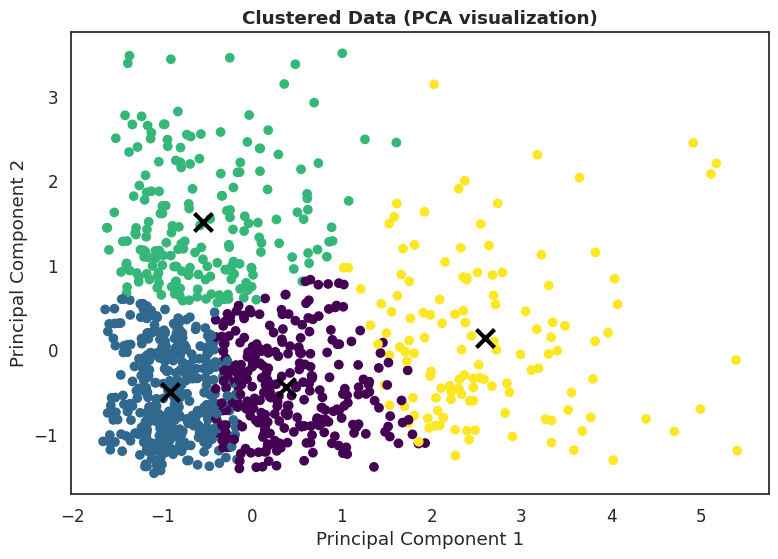

In [84]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
pca_2_result = pca_2.fit_transform(data_num_std)

## obtém os centrois do k-means e aplica a transformação por PCA
centroids = kmeans_final.cluster_centers_
centroids_pca = pca_2.transform(centroids)

## plota a figura, colorindo os pontos de acordo com o respectivo cluster.
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()

### **Interpretação dos resultados**

A análise de agrupamentos tem como resultado a geração de **clusters** que são definidos com base na **alta similaridades entre as características** (ou atributos) **das instâncias**. Assim, usualmente o resultado do agrupamento precisa ser explorado visualmente, através de gráficos, tabelas ou estatística descritiva, e interpretado.

Nesta seção do documento, os grupos deverão implementar suas estratégias para **analisar e comparar** a distribuição dos atributos entre os clusters encontrados. **O objetivo é traçar um perfil dos clientes que se encaixa em cada cluster obtido, com base nos atributos disponíveis** (numéricos e categóricos, incluindo aqueles que não foram usados para realizar o agrupamento). Ao final da análise, os grupos devem ser capazes de realizar uma descrição de cada cluster em termos do perfil de cliente que ele melhor representa.

Por exemplo... Algum cluster está associado com pessoas mais jovens? Como está distribuído o valor de crédito em cada cluster? Existe uma proporção maior de mulheres em algum cluster? Existe alguma relação entre os clusters e o tipo de emprego, de moradia, ou de contas (poupança e correnta)? etc. Os grupos podem (e devem) usar a criatividade para realizar a análise dos dados e a interpretação dos dados.

Sugere-se uso de recursos como média e desvio padrão, gráfico de barras, graficos de boxplot, histogramas, ou outros apropriados para análise de distribuição (de acordo com o tipo de atributo, numérico ou categórico).

Os resultados devem ser apresentados e discutidos no próprio notebook do Google Colab ou, alternativamente, em relatório em PDF a ser entregue junto com o notebook.




#### Interpretação com Gráficos


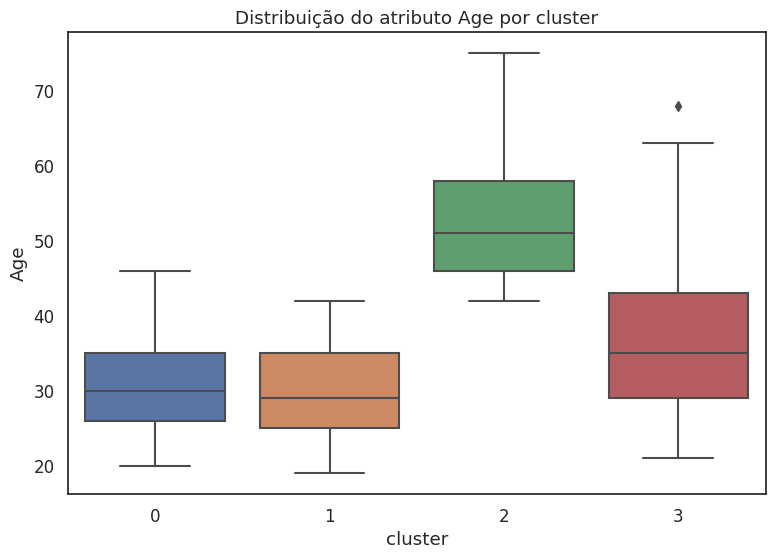

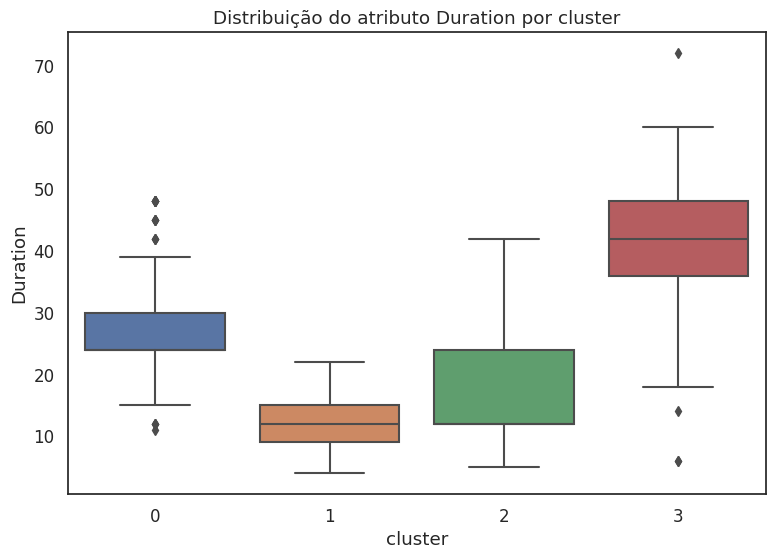

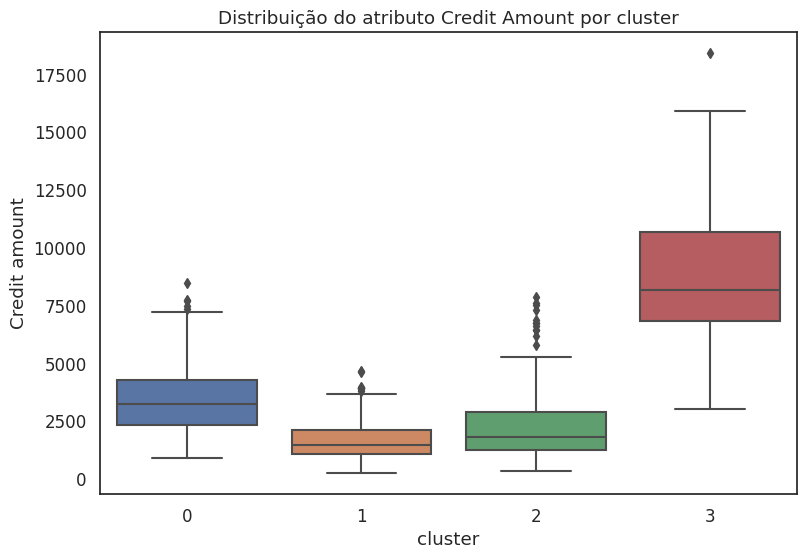

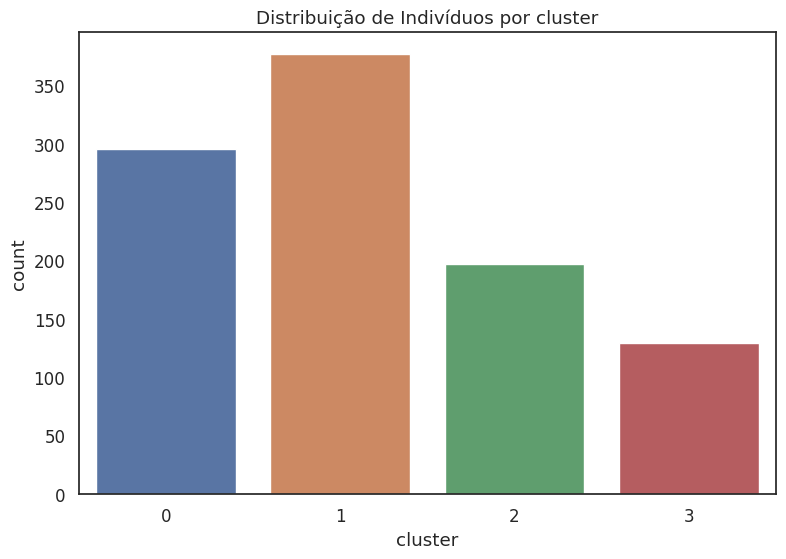

In [89]:

sns.boxplot(x='cluster', y='Age', data=clusters_config_original)
plt.title(f'Distribuição do atributo Age por cluster')
plt.show()

sns.boxplot(x='cluster', y='Duration', data=clusters_config_original)
plt.title(f'Distribuição do atributo Duration por cluster')
plt.show()

sns.boxplot(x='cluster', y='Credit amount', data=clusters_config_original)
plt.title(f'Distribuição do atributo Credit Amount por cluster')
plt.show()

sns.countplot(x='cluster', data=clusters_config_original)
plt.title(f'Distribuição de Indivíduos por cluster')
plt.show()

Nos gráficos acima, é possível observar uma separação dos clusters baseado nos dados numéricos que foram apresentados.

* Os perfis configurado pelo cluster de número 1 e 2, consistem em pessoas de baixo crédito, porém separados por idade. No cluster número 1, que comporta a maior quantidade de instâncias, existem pessoas predominantemente entre 25 e 35 anos. No cluster número 2, estão pessoas predominantemente com mais de 45 anos.

* O perfil configurado pelo cluster de número 3, consiste em pessoas com uma quantidade de crédito mais elevada, e de idade majoritariamente entre 30 e 45 anos.

* O perfil configurado pelo cluster de número 0, apresenta pessoas jovens, assim como no cluster 1, com valores de crédito e duração que podem ser considerados medios (valores nem altos nem baixos).

Podemos também perceber através desses agrupamentos que a duração dos empréstimos está relacionada a quantidade de crédito disponível para aquele grupo.

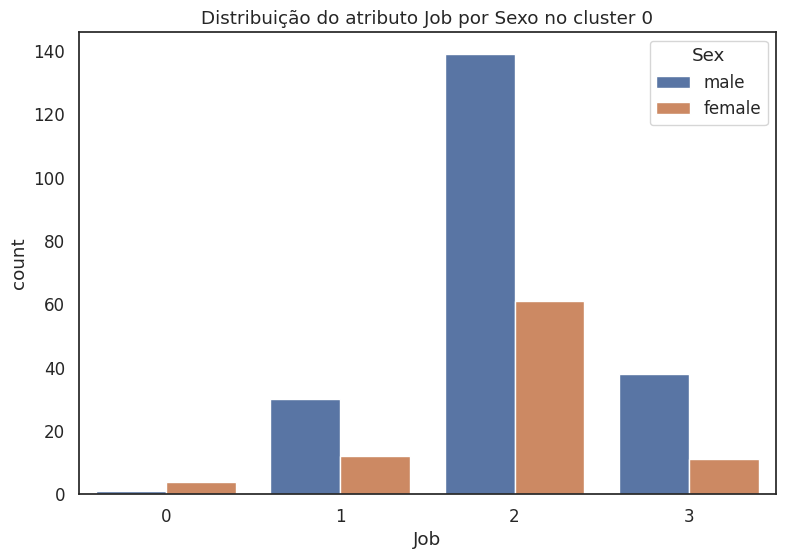

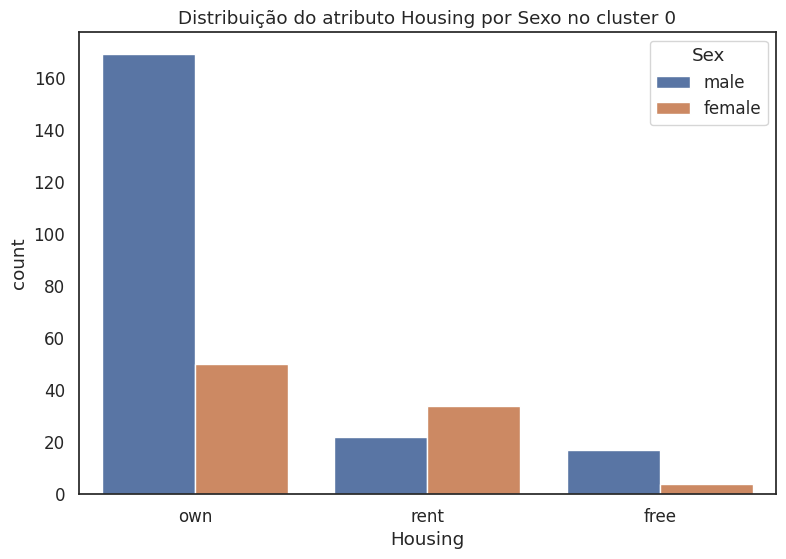

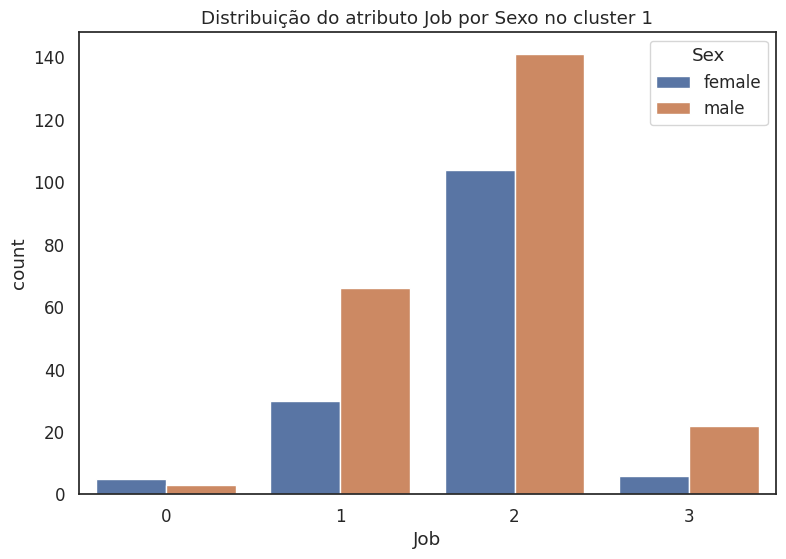

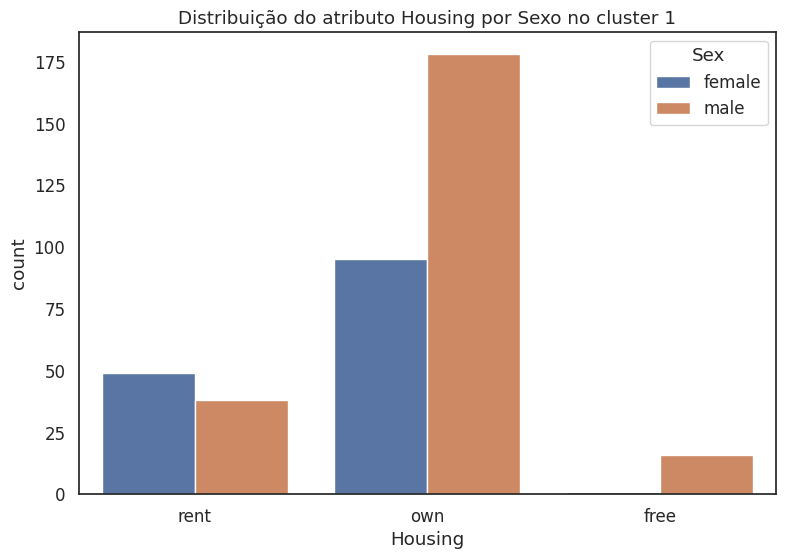

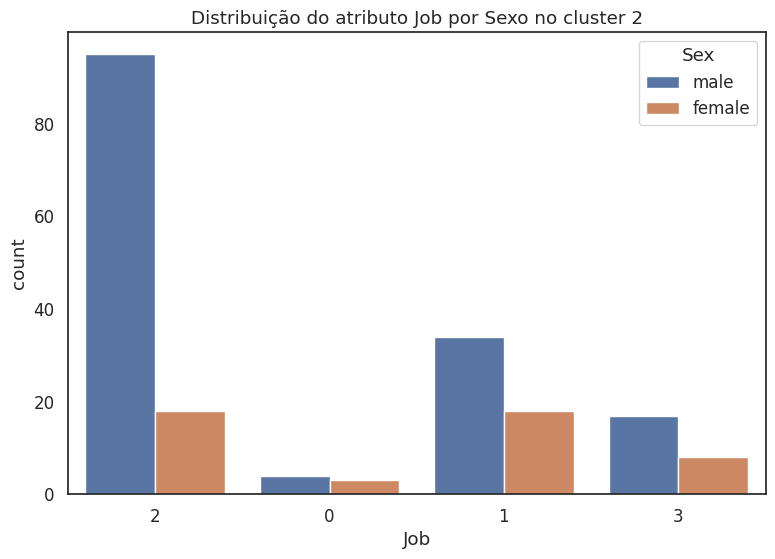

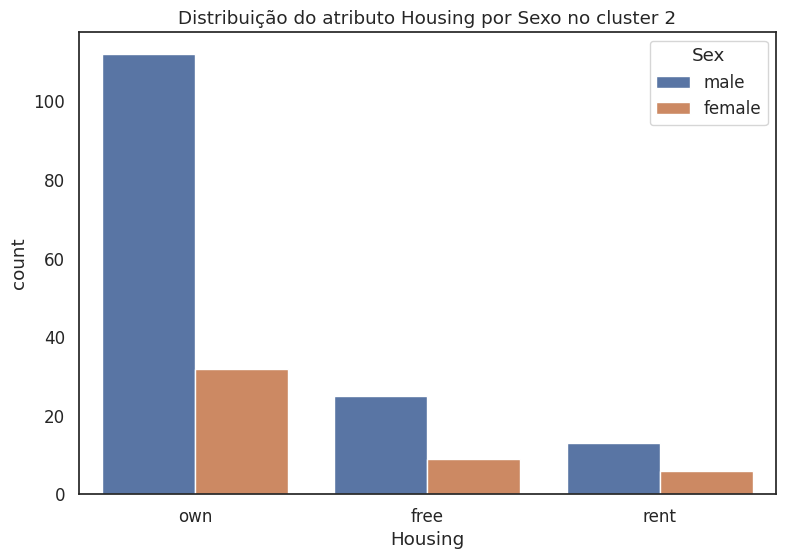

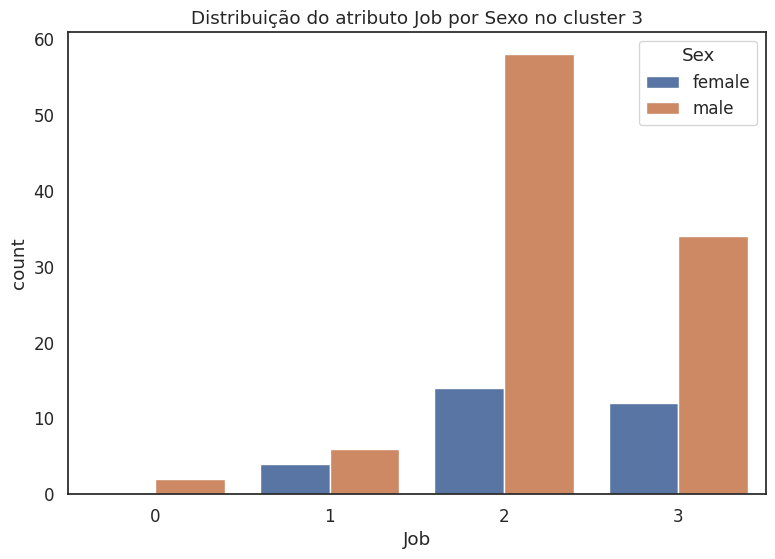

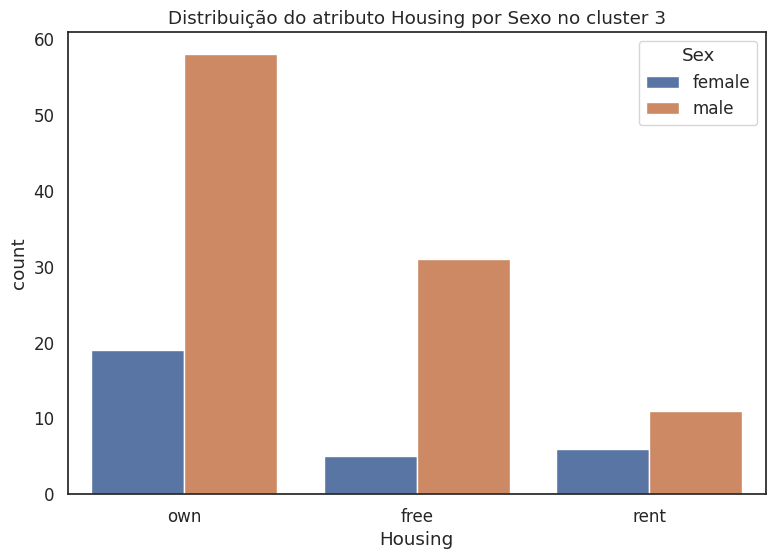

In [90]:

for cluster in range(num_clusters):
  for coluna in ['Job','Housing']:
      sns.countplot(x=coluna, data=clusters_config_original.where(clusters_config_original['cluster'] == cluster), hue='Sex')
      plt.title(f'Distribuição do atributo {coluna} por Sexo no cluster {cluster}')
      plt.show()

Os gráficos acima nos permitem complementar algumas suposições sobre os perfis citados anteriormente:

* O cluster 0 possui pessoas com um emprego médio-alto que possuem casa própria.

* O cluster 1 possui uma distribuição mais representativa do dataset total de homens e mulheres, predominantemente em empregos médio-baixos e médio-altos.

* O cluster 2 possui majoritariamente homens em empregos médio-altos.

* O cluster 3 possui pessoas em empregos médio-altos e altos que possuem casa própria ou moradia sem custo.

### **Exemplos de gráficos**

Os exemplos abaixos são dados sem considerar a informação de clusters, apenas os atributos originais, para auxiliar os alunos em algumas visualizações possíveis. Outras visualizações podem ser utilizadas a critério dos alunos.

#### Analisando a distribuição de uma variável numérica para subgrupos (dados por variável categórica)

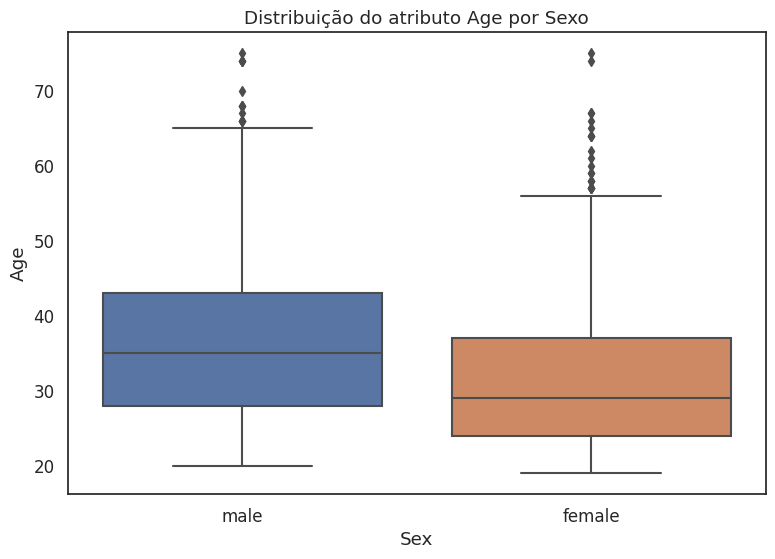

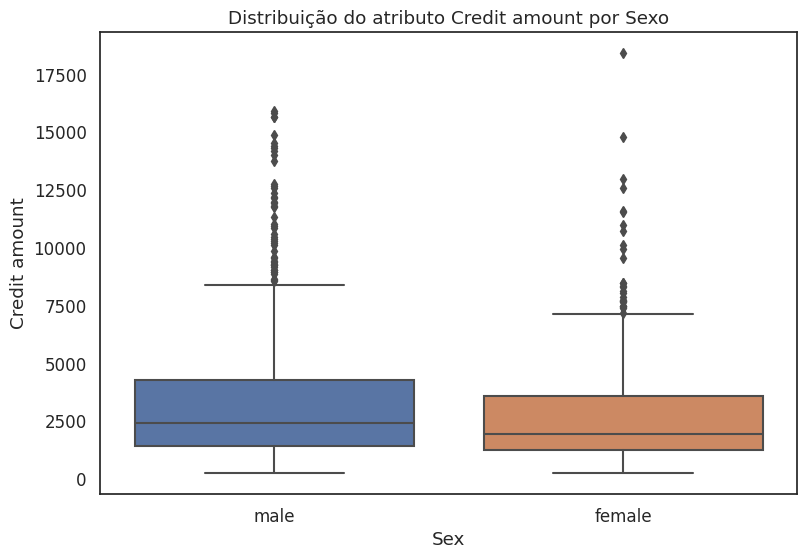

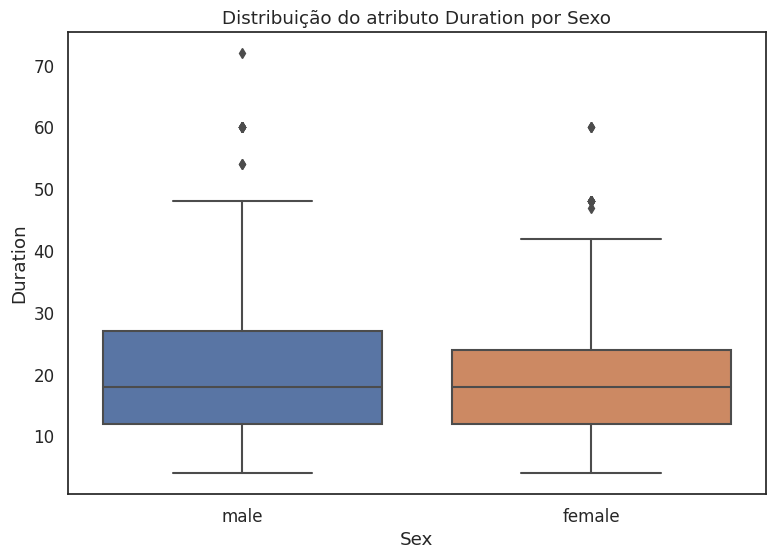

In [87]:
# boxplots
for coluna in data_num.columns:  ## usando apenas colunas numéricas com base no dataframe data_num
    sns.boxplot(x='Sex', y=coluna, data=clusters_config_original)
    plt.title(f'Distribuição do atributo {coluna} por Sexo')
    plt.show()

#### Analisando a distribuição de uma variável categórica para subgrupos (dados por variável categórica)

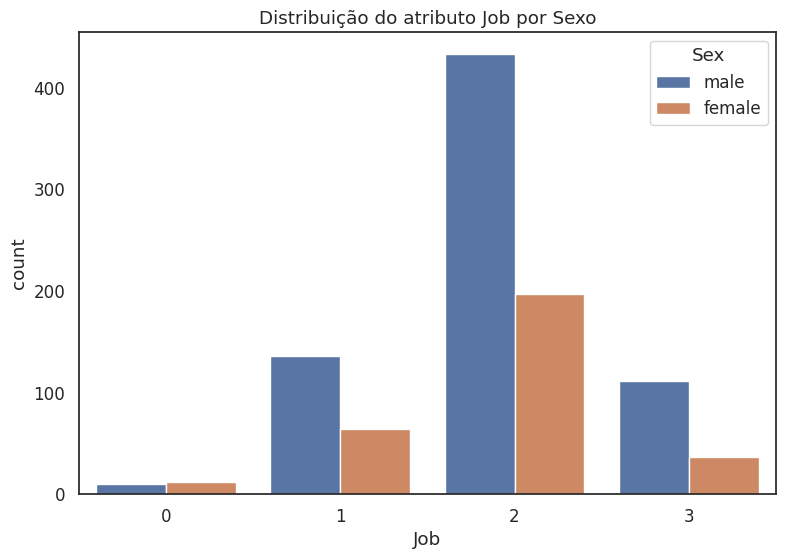

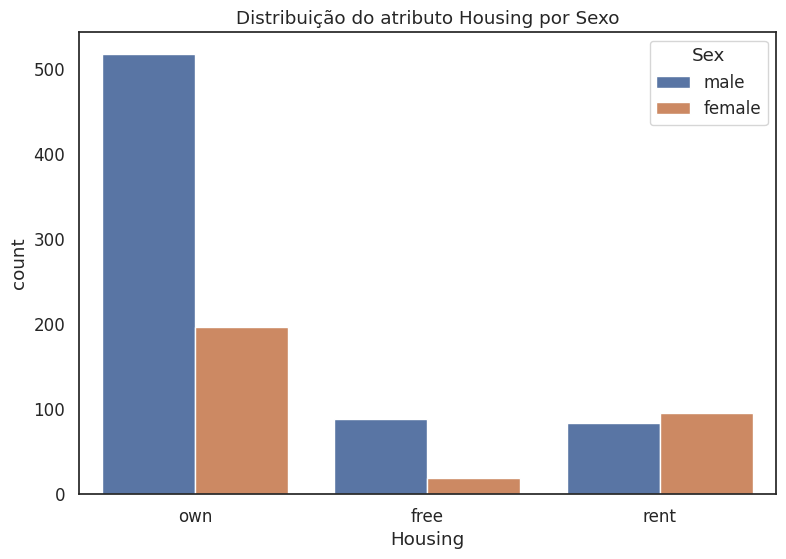

In [88]:
# barplots
for coluna in ['Job','Housing']:  ## usando apenas colunas numéricas com base no dataframe data_num
    sns.countplot(x=coluna, data=data_cat, hue='Sex')
    plt.title(f'Distribuição do atributo {coluna} por Sexo')
    plt.show()